In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import generative as gen
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
import utils as ut
import seaborn as sns
from vizman import viz
from scipy import io
import pandas as pd
from brainspace.utils import parcellation
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from netneurotools.networks import struct_consensus


/Users/kf02/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
viz.set_visual_style()
viz_sizes = viz.load_data_from_json("sizes.json")
viz_colors = viz.load_data_from_json("colors.json")
viz_cmaps = viz.give_colormaps()
sns_kwargs = {"cmap": viz_cmaps["bw_lr"],
              "xticklabels":False,
              "yticklabels":False,
              "rasterized":True}

surfcolors = sns.blend_palette([
                                viz_colors["neutrals"]["ALL_WHITE"],
                                viz_colors["warms"]["LECKER_RED"]],
                                     as_cmap=True)

In [4]:
data = io.loadmat(
    "datasets/human/lifespan/lifespan_project_data.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)

In [5]:
data["lifespan_project_data"]["sample"]["info"]

array(['Sex: male = 0, female = 1',
       'Study_ids contains ids for each study - for BCP this includes the session and scan type',
       'Subject_ids are numbers that are unique to each unique subject and repeat for index that contain the same subject but different scan (either session or scan type)',
       'Atlas: neonatal = 1; 1-year-old = 2, 2-year-old = 3; adult = 4',
       'Study: dHCP = 1, BCP = 2 , CALM = 3, RED = 4, ACE = 5, HCPd = 6, HCPya = 7, camCAN = 8, HCPa = 9',
       'Neurogroup: neurotypical = 1, neurodiverse = 2'], dtype=object)

In [6]:
data["lifespan_project_data"]["sample"].keys()

dict_keys(['info', 'study_ids', 'subject_ids', 'ages', 'sex', 'atlas', 'studies', 'neurogroup'])

In [7]:
connectomes = data["lifespan_project_data"]["connectomes"]["controlled_density"]["binarised"]

In [94]:
weighted_connectomes = data["lifespan_project_data"]["connectomes"]["controlled_density"]["weighted"]

In [8]:
atlas = io.loadmat(
    "datasets/human/lifespan/aal90.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)

In [9]:
labels = atlas["aal90"]["region_labels"]
coordinates = atlas["aal90"]["coor_adult"]
euclidean_distances = squareform(pdist(coordinates))

lh_vertex_labels = np.load("./datasets/human/lifespan/AAL90_lh_labels.npy")
rh_vertex_labels = np.load("./datasets/human/lifespan/AAL90_rh_labels.npy")

In [15]:
info = pd.DataFrame({"sex": data["lifespan_project_data"]["sample"]["sex"],
                     "subject_ids": data["lifespan_project_data"]["sample"]["subject_ids"],
                     "atlas": data["lifespan_project_data"]["sample"]["atlas"],
                     "ages": data["lifespan_project_data"]["sample"]["ages"],
                     "studies": data["lifespan_project_data"]["sample"]["studies"],
                     "neurogroup": data["lifespan_project_data"]["sample"]["neurogroup"],})

In [74]:
hcp_ya = connectomes[info["studies"] == 7].transpose(1, 2, 0)
hcp_ya.shape

(90, 90, 1062)

In [79]:
(connectomes[info["studies"] == 7][0,:,:] == hcp_ya[:,:,0]).all()

True

In [96]:
hemiid = np.zeros(90)
hemiid[::2] = 1  # Set every even index to 1

In [ ]:

weighted_hcp_ya = weighted_connectomes[info["studies"] == 7].transpose(1, 2, 0)
empirical_consensus = struct_consensus(weighted_hcp_ya, 
                                       distance=euclidean_distances,
                                       hemiid=hemiid.reshape(-1, 1))

In [53]:
n_iterations = 3_000
n_nodes = labels.shape[0]
beta = np.full(n_iterations, 1)
noise = np.zeros(n_iterations)
penalty = np.zeros(n_iterations)
batch_size = np.full(n_iterations, 8)

start = 1
stop = 1.4
params = np.linspace(start, stop, 11)
# scores = np.zeros(len(params))
# histories = np.zeros((n_nodes, n_nodes, n_iterations, len(params)))
# densities = np.zeros(len(params))
# for ind, val in enumerate(params):
#     alpha = np.full(n_iterations, val)
#     histories[...,ind] = gen.simulate_network_evolution(
#         coordinates=coordinates,
#         n_iterations=n_iterations,
#         alpha=alpha,
#         beta=np.full(n_iterations, 1),
#         noise=noise,
#         distance_fn=gen.resistance_distance,
#         connectivity_penalty=penalty,
#         n_jobs=-1,
#         random_seed=11,
#         batch_size=batch_size,
#     )
#     scores[ind] = ut.density_distance(histories[:,:,-1,ind],
#                                       empirical_consensus, 
#                                       absolute=False)
#     densities[ind] = ut.check_density(histories[:,:,-1,ind])
#     print(f"Parameter {val} error: {scores[ind]:.4f}")
# np.save("simulations/diffusion_HCPya_3k_scores.npy",scores)
# np.save("simulations/diffusion_HCPya_3k_matrices.npy",histories)
# np.save("simulations/diffusion_HCPya_3k_densities.npy",densities)

Simulating network evolution: 100%|██████████| 2999/2999 [00:38<00:00, 76.93it/s]


Parameter 1.0 error: -0.0089


Simulating network evolution: 100%|██████████| 2999/2999 [00:38<00:00, 77.50it/s]


Parameter 1.04 error: -0.0089


Simulating network evolution: 100%|██████████| 2999/2999 [00:38<00:00, 77.42it/s]


Parameter 1.08 error: -0.0057


Simulating network evolution: 100%|██████████| 2999/2999 [00:39<00:00, 76.80it/s]


Parameter 1.1199999999999999 error: -0.0047


Simulating network evolution: 100%|██████████| 2999/2999 [00:39<00:00, 76.37it/s]


Parameter 1.16 error: 0.0002


Simulating network evolution: 100%|██████████| 2999/2999 [00:39<00:00, 76.65it/s]


Parameter 1.2 error: -0.0012


Simulating network evolution: 100%|██████████| 2999/2999 [00:38<00:00, 76.99it/s]


Parameter 1.24 error: -0.0012


Simulating network evolution: 100%|██████████| 2999/2999 [00:38<00:00, 77.00it/s]


Parameter 1.28 error: 0.0025


Simulating network evolution: 100%|██████████| 2999/2999 [00:40<00:00, 73.97it/s]


Parameter 1.3199999999999998 error: 0.0032


Simulating network evolution: 100%|██████████| 2999/2999 [00:40<00:00, 73.19it/s]


Parameter 1.3599999999999999 error: 0.0064


Simulating network evolution: 100%|██████████| 2999/2999 [00:41<00:00, 73.08it/s]


Parameter 1.4 error: 0.0074


In [105]:
densities = np.load("simulations/diffusion_HCPya_3k_densities.npy")
scores = np.load("simulations/diffusion_HCPya_3k_scores.npy")
histories = np.load("simulations/diffusion_HCPya_3k_matrices.npy")

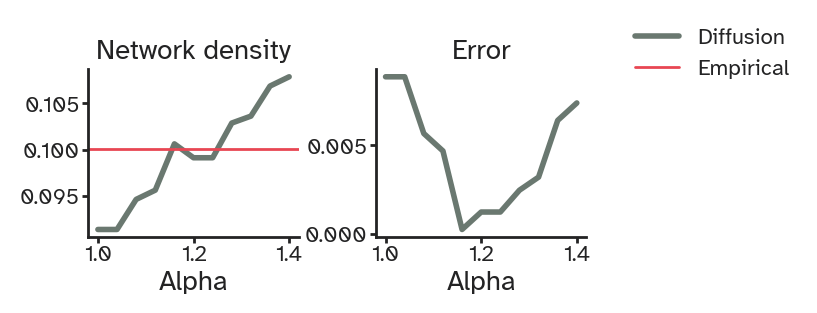

In [106]:
fig, axes = plt.subplot_mosaic([["A", "B"]], 
                               figsize=(viz.cm_to_inch((8,4))),
                               dpi=200,sharex=True)
axes["A"].plot(params,densities,lw=2,label="Diffusion")
axes["A"].axhline(ut.check_density(empirical_consensus),
                  color=viz_colors["warms"]["LECKER_RED"],label="Empirical")

axes["B"].plot(params,np.abs(scores),lw=2)

axes["A"].set_title("Network density")
axes["B"].set_title("Error")
axes["A"].set_xlabel("Alpha")
axes["B"].set_xlabel("Alpha")
fig.legend(bbox_to_anchor=(1.3,1),frameon=False)
fig.tight_layout(w_pad=0.1)
sns.despine()
plt.savefig("figures/HCP/res1_densities_errors.pdf",dpi=600,bbox_inches='tight');

In [114]:
# n_iterations = 10_000
# alpha = np.full(n_iterations, params[np.argmin(scores)])
# best_model = gen.simulate_network_evolution(
#     coordinates=coordinates,
#     n_iterations=n_iterations,
#     alpha=alpha,
#     beta=np.full(n_iterations, 1),
#     noise=np.zeros(n_iterations),
#     distance_fn=gen.resistance_distance,
#     connectivity_penalty=np.zeros(n_iterations),
#     n_jobs=-1,
#     random_seed=11,
#     batch_size=np.full(n_iterations, 8),
# )
# np.save("simulations/diffusion_HCPya_10k_best.npy",best_model)
best_model = np.load("simulations/diffusion_HCPya_10k_best.npy")

Simulating network evolution: 100%|██████████| 9999/9999 [02:11<00:00, 76.30it/s]


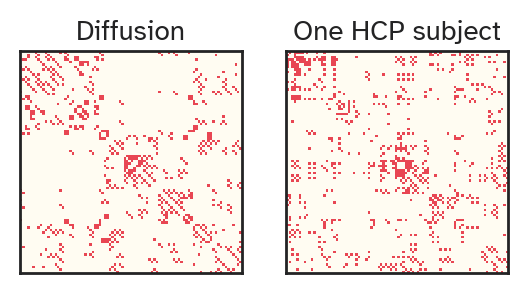

In [115]:
fig, axes = plt.subplot_mosaic([["A", "B"]], 
                               figsize=(viz.cm_to_inch((8,4))),
                               dpi=200)
viz.plot_matrix(best_model[:,:,-1],
                cbar=False,sns_kwargs=sns_kwargs,axis=axes["A"])
viz.plot_matrix(hcp_ya[:,:,15], 
                cbar=False, sns_kwargs=sns_kwargs, axis=axes["B"])
axes["A"].set_title("Diffusion")
axes["B"].set_title("One HCP subject")
plt.savefig("figures/HCP/example_adjmats.pdf",dpi=600,bbox_inches='tight');

In [116]:
simulated_networks = best_model[:,:,-hcp_ya.shape[-1]:]
simulated_networks.shape == hcp_ya.shape

True

In [174]:
empirical_similarity = np.zeros((hcp_ya.shape[0],hcp_ya.shape[-1]))
simulated_similarity = np.zeros((hcp_ya.shape[0],hcp_ya.shape[-1]))
for subject in range(hcp_ya.shape[-1]):
    empirical_similarity[:,subject] = ut.calculate_endpoint_similarity(hcp_ya[:,:,subject],
                                                                       empirical_consensus)
    simulated_similarity[:,subject] = ut.calculate_endpoint_similarity(simulated_networks[:,:,subject],
                                                                       empirical_consensus)
    
empirical_similarity = pd.DataFrame(empirical_similarity.T,columns=labels)
simulated_similarity = pd.DataFrame(simulated_similarity.T,columns=labels)

In [175]:
left_data = empirical_similarity.iloc[:,::2].copy()
right_data = empirical_similarity.iloc[:,1::2].copy()
left_surfdata = parcellation.map_to_labels(left_data.mean(1),lh_vertex_labels)
right_surfdata = parcellation.map_to_labels(right_data.mean(1),rh_vertex_labels)

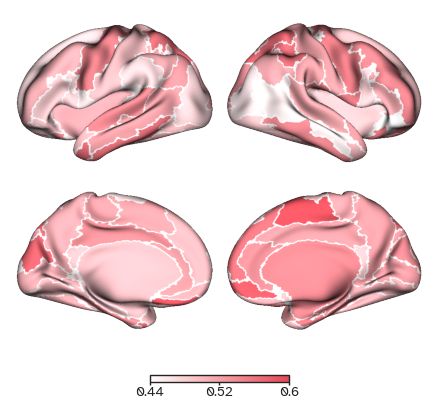

In [212]:
surfaces = fetch_fslr()
lh, rh = surfaces['inflated']


p = Plot(surf_lh=lh, surf_rh=rh,
         brightness=0.8)
p.add_layer({'left':left_surfdata, 
             'right':right_surfdata}, 
            cmap=surfcolors)

p.add_layer({'left':left_surfdata, 
             'right':right_surfdata}, 
            cmap='binary_r',as_outline=True,cbar=False)
fig = p.build()
fig.savefig("figures/HCP/ES_empirical.pdf", dpi=600, bbox_inches="tight")

In [ ]:
# diffusion_measures = ut.compute_graph_metrics_parallel(simulated_networks,
#                                                     empirical_consensus,
#                                                     euclidean_distances,
#                                                     coordinates)
# diffusion_measures.to_csv("results/HCP/diffusion_measures.csv",index=False)
diffusion_measures = pd.read_csv("results/HCP/diffusion_measures.csv")

In [ ]:
# empirical_measures = ut.compute_graph_metrics_parallel(hcp_ya,
#                                                     empirical_consensus,
#                                                     euclidean_distances,
#                                                     coordinates)
# empirical_measures.to_csv("results/HCP/empirical_measures.csv",index=False)
empirical_measures = pd.read_csv("results/HCP/empirical_measures.csv")

In [118]:
from bct import randmio_und, latmio_und

In [ ]:
# randomized_networks = np.zeros_like(hcp_ya)
# latticized_networks = np.zeros_like(hcp_ya)

# for subject in tqdm(range(hcp_ya.shape[2])):
#     # randmio_und returns a tuple (randomized_matrix, num_swaps)
#     # we only want the randomized matrix
#     randomized_networks[:,:,subject] = randmio_und(hcp_ya[:,:,subject],
#                                                    itr=32, seed=subject)[0]
#     # latmio_und returns a tuple (latticized_matrix, num_swaps)
#     # we only want the latticized matrix
#     latticized_networks[:,:,subject] = latmio_und(hcp_ya[:,:,subject],
#                                                   itr=32, seed=subject)[0]

# np.save("results/HCP/randomized_networks.npy",randomized_networks)
# np.save("results/HCP/latticized_networks.npy",latticized_networks)

randomized_networks = np.load("results/HCP/randomized_networks.npy")
latticized_networks = np.load("results/HCP/latticized_networks.npy")

In [ ]:
# randomized_measures = ut.compute_graph_metrics_parallel(randomized_networks,
#                                                      empirical_consensus,
#                                                      euclidean_distances,
#                                                      coordinates)
# latticized_measures = ut.compute_graph_metrics_parallel(latticized_networks,
#                                                      empirical_consensus,
#                                                      euclidean_distances,
#                                                      coordinates)
# randomized_measures.to_csv("results/HCP/randomized_measures.csv",index=False)
# latticized_measures.to_csv("results/HCP/latticized_measures.csv",index=False)

randomized_measures = pd.read_csv("results/HCP/randomized_measures.csv")
latticized_measures = pd.read_csv("results/HCP/latticized_measures.csv")

In [122]:
# measure_labels = ["diffusion distance",
#                     "shortest path distance",
#                     "propagation distance",
#                     "topological distance",
#                     "density",
#                     "wiring cost",
#                     "average clustering",
#                     "degree assortativity",
#                     "small-worldness",
#                     "endpoint similarity",
#                     "accuracy",
#                     "F1 score"]

# consensus_measures = np.zeros(len(measure_labels))
# consensus_measures[0] = gen.resistance_distance(empirical_consensus,coordinates).mean()
# consensus_measures[1] = gen.shortest_path_distance(empirical_consensus,coordinates).mean()
# consensus_measures[2] = gen.propagation_distance(empirical_consensus,coordinates).mean()
# consensus_measures[3] = gen.topological_distance(empirical_consensus,coordinates).mean()

# consensus_measures[4] = ut.check_density(empirical_consensus)
# consensus_measures[5] = ut.calculate_wiring_cost(empirical_consensus,euclidean_distances)
# G = nx.from_numpy_array(empirical_consensus)
# consensus_measures[6] = nx.average_clustering(G)
# consensus_measures[7] = nx.degree_assortativity_coefficient(G)
# consensus_measures[8] = ut.compute_omega(empirical_consensus)
# consensus_measures = pd.DataFrame([consensus_measures], columns=measure_labels)
# consensus_measures.to_csv("results/HCP/consensus_measures.csv",index=False)

consensus_measures = pd.read_csv("results/HCP/consensus_measures.csv")

Computing graph metrics:   0%|          | 0/1062 [36:15<?, ?it/s]


In [129]:

diffusion_measures['model'] = 'Diffusion'
empirical_measures['model'] = 'Empirical'
latticized_measures['model'] = 'Latticized'
randomized_measures['model'] = 'Randomized'

all_measures = pd.concat([
    diffusion_measures,
    empirical_measures,
    latticized_measures,
    randomized_measures,
], axis=0).reset_index(drop=True)

all_measures['sample_id'] = all_measures.groupby('model').cumcount()

all_measures.replace([np.inf, -np.inf], np.nan, inplace=True)
all_measures.to_csv("results/HCP/all_measures.csv",index=False)

all_measures = pd.read_csv("results/HCP/all_measures.csv")

In [130]:
all_measures.head()

,diffusion distance,shortest path distance,propagation distance,topological distance,density,wiring cost,average clustering,degree assortativity,small-worldness,endpoint similarity,accuracy,F1 score,model,sample_id
0,9.566843,2.929630,1.753821,0.907004,0.092135,2.769645,0.379241,0.029662,0.196780,0.226554,85.382716,0.231169,Diffusion,0
1,9.566248,2.930864,1.753724,0.907000,0.092135,2.765488,0.380822,0.027299,0.188738,0.226374,85.382716,0.231169,Diffusion,1
2,9.566248,2.930864,1.753724,0.907000,0.092135,2.765488,0.380822,0.027299,0.194700,0.226374,85.382716,0.231169,Diffusion,2
3,9.536797,2.929630,1.745078,0.906762,0.092385,2.774631,0.382189,0.023736,0.198406,0.225960,85.358025,0.230869,Diffusion,3
4,9.496854,2.925185,1.735657,0.906575,0.092634,2.783316,0.382402,0.040847,0.188047,0.225849,85.333333,0.230570,Diffusion,4


In [127]:
colors = [viz_colors["neutrals"]["OLIVE_GRAY"], # diffusion
          viz_colors["warms"]["LECKER_RED"], # empirical
          viz_colors["neutrals"]["GRAY"], # latticized
          viz_colors["neutrals"]["GRAY"]] # randomized

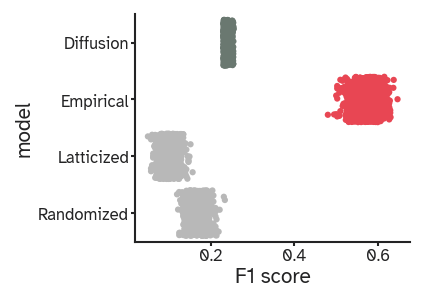

In [148]:
plt.figure(figsize=(viz.cm_to_inch((6,5))), dpi=150)
measure = "F1 score"
sns.stripplot(data=all_measures, 
              y="model",
              x=measure,
              hue="model",
              size=3,
              jitter=0.4,
              palette=colors)

empirical_values = all_measures[all_measures['model'] == 'Empirical'][measure]
plt.xlabel(measure.capitalize())

#plt.xlim(0.05,0.15)
sns.despine()
plt.savefig(f"figures/HCP/{measure}_stripplot.pdf",dpi=600,bbox_inches='tight');

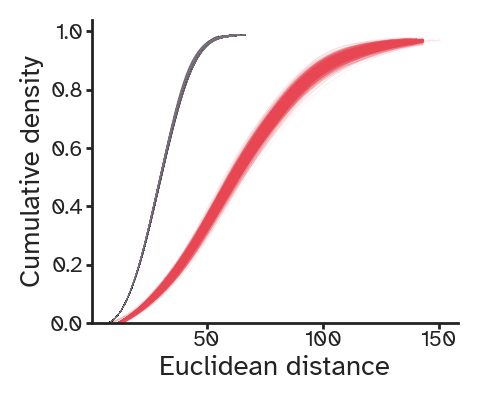

In [159]:
plt.figure(figsize=(viz.cm_to_inch((6,5))), dpi=200)
cumu = True

for subject in range(hcp_ya.shape[2]):
    sns.kdeplot(euclidean_distances[hcp_ya[:,:,subject].astype(bool)],
                lw=0.2,
                alpha=0.1,
                color=viz_colors["warms"]["LECKER_RED"],
                bw_adjust=1.5,cut=0,cumulative=cumu)
    sns.kdeplot(euclidean_distances[simulated_networks[:,:,subject].astype(bool)],
                lw=0.2,
                alpha=0.1,
                bw_adjust=1.5,cut=0,cumulative=cumu)


plt.xlabel('Euclidean distance')
plt.ylabel('Cumulative density')
sns.despine()
plt.savefig("figures/HCP/cumu_kdeplot.pdf",dpi=600,bbox_inches='tight');